# Hyperparameter Tuning For Neural Network

1. Number of units for single dense layer
2. Regulatisation to use
3. Dropout to use
4. Number of epochs to train for

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import string
import hyperopt
import time

In [2]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix, hstack, vstack
from sklearn import metrics
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from gensim.parsing.preprocessing import remove_stopwords
from lightgbm import LGBMClassifier

In [3]:
train = pd.read_csv("../datasets/preprocessed_train.csv")
test = pd.read_csv("../datasets/preprocessed_test.csv")

In [4]:
import re
# Only repalce numbers and nothing else
train["Comment"] = train["Comment"].apply(lambda x: re.sub('\d', '1', x.lower()))
test["Comment"] = test["Comment"].apply(lambda x: re.sub('\d', '1', x.lower()))

#### Getting train test for neural network is different from LGBM and Catboost. Here we are just using tfidf character level features.

In [5]:
def get_train_test(train, test = None, ngram_range = (1,1), max_features=None, random_state=1, test_size=0.1, min_df=50):
    
    if type(test) != pd.core.frame.DataFrame:
        
        X = train.Comment
        y = train.Outcome
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=random_state, test_size=test_size)
        
        tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=ngram_range, max_features=max_features, min_df=min_df)

        print("Fitting...")
        start = time.time()
        X_train_dtm =  tfidf_vect_ngram_chars.fit_transform(X_train) 
        X_val_dtm =  tfidf_vect_ngram_chars.transform(X_val) 
        print(f"Operation Took {round(start-time.time(), 2)}s")
        
        from imblearn.over_sampling import RandomOverSampler
        ros = RandomOverSampler(random_state=0)
        X_train_dtm, y_train = ros.fit_resample(X_train_dtm, y_train)
        
        print("X_train: ", X_train_dtm.shape)
        print("X_val: ", X_val_dtm.shape)
        
        return X_train_dtm.tocsr(), X_val_dtm.tocsr(), y_train, y_val
    else:
        tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=ngram_range, max_features=max_features, min_df=min_df)

        print("Fitting...")
        start = time.time()
        X_train_dtm =  tfidf_vect_ngram_chars.fit_transform(train.Comment) 
        X_test_dtm =  tfidf_vect_ngram_chars.transform(test.Comment) 
        print(f"Operation Took {time.time()-start}s")
        print(X_train_dtm.shape, X_test_dtm.shape)
        
        from imblearn.over_sampling import RandomOverSampler
        ros = RandomOverSampler(random_state=0)
        X_train_dtm, y_train = ros.fit_resample(X_train_dtm, train.Outcome)
    
        print("X_train: ", X_train_dtm.shape)
        print("X_test: ", X_test_dtm.shape)
        
        return X_train_dtm, X_test_dtm, y_train
    

In [6]:
start = time.time()
X_train, X_val, y_train, y_val = get_train_test(train, test = None, ngram_range = (2,5), 
                    max_features=None, random_state=1, test_size=0.1)

Fitting...
Operation Took -165.32s


Using TensorFlow backend.


X_train:  (45028, 91675)
X_val:  (4446, 91675)


In [7]:
from __future__ import division
import numpy as np

# This plot helps to visualise the history of epochs and performance on validation and training set
# We can analyse and know what's going on
def plot_history(history):
    # Plot loss and accuracy 
    fig = plt.figure(figsize=(10,5))

    #plt.subplot(1, 2, 1)
    plt.plot(history.epoch, history.history['val_loss'], 'g-', label='Validation data')
    plt.plot(history.epoch, history.history['loss'], 'r--', label='Training data')
    plt.grid(True)
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss on training/validation data')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    #plt.subplot(1, 2, 2)
    fig = plt.figure(figsize=(10,5))
    plt.plot(history.epoch, history.history['val_accuracy'], 'g-', label='Validation data')
    plt.plot(history.epoch, history.history['accuracy'], 'r--', label='Training data')
    plt.grid(True)
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy on training/validation data')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

# Dense Layer 100

Train on 45028 samples, validate on 4446 samples
Epoch 1/6
 - 98s - loss: 0.5740 - accuracy: 0.7037 - val_loss: 0.5322 - val_accuracy: 0.7272
Epoch 2/6
 - 98s - loss: 0.4475 - accuracy: 0.7962 - val_loss: 0.5265 - val_accuracy: 0.7377
Epoch 3/6
 - 97s - loss: 0.3687 - accuracy: 0.8457 - val_loss: 0.5537 - val_accuracy: 0.7283
Epoch 4/6
 - 97s - loss: 0.3038 - accuracy: 0.8797 - val_loss: 0.5866 - val_accuracy: 0.7260
Epoch 5/6
 - 109s - loss: 0.2447 - accuracy: 0.9082 - val_loss: 0.6249 - val_accuracy: 0.7265
Epoch 6/6
 - 98s - loss: 0.1946 - accuracy: 0.9338 - val_loss: 0.6811 - val_accuracy: 0.7150


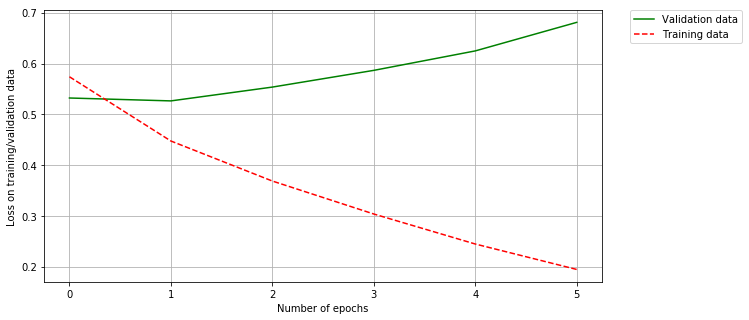

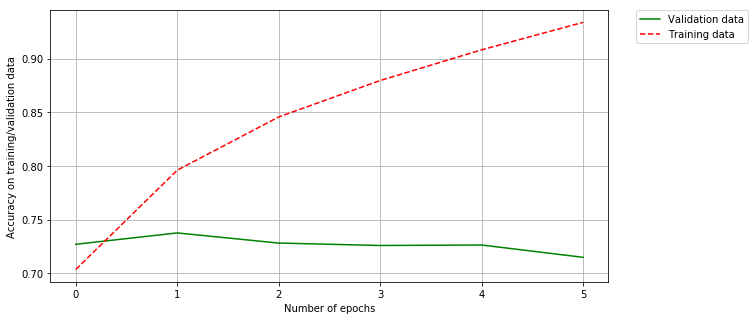

In [8]:
from numpy.random import seed
seed(1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras
from keras.layers.advanced_activations import LeakyReLU, PReLU
# define network
model = Sequential()
model.add(Dense(100, input_shape=(X_train.shape[1],), activation="linear",
                kernel_initializer=keras.initializers.he_normal(seed=1)))
model.add(Activation('relu'))

#model.add(LeakyReLU(alpha=.3))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=6, verbose=2, validation_data=(X_val, y_val), batch_size = 256)
plot_history(history)

In [9]:
print("Train")
y_pred_class = model.predict_proba(X_train)
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_train)
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))

print("Validation")
y_pred_class = model.predict(X_val)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_val)
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class))

Train
Accuracy:  0.9725059962689881
Auroc:  0.9958202322428079
Validation
Accuracy:  0.7150247413405308
Auroc:  0.7858656693415321


#### Here we see that there is some overfitting going on, validation data does worse with just a few epochs and we need to either introduce regularization of reduce units in dense layer or to increase dropout. We decrease units first

# Dense Layer 50

Train on 45028 samples, validate on 4446 samples
Epoch 1/6
 - 79s - loss: 0.5872 - accuracy: 0.6980 - val_loss: 0.5397 - val_accuracy: 0.7272
Epoch 2/6
 - 78s - loss: 0.4721 - accuracy: 0.7849 - val_loss: 0.5222 - val_accuracy: 0.7389
Epoch 3/6
 - 77s - loss: 0.4022 - accuracy: 0.8278 - val_loss: 0.5331 - val_accuracy: 0.7312
Epoch 4/6
 - 78s - loss: 0.3449 - accuracy: 0.8593 - val_loss: 0.5536 - val_accuracy: 0.7323
Epoch 5/6
 - 82s - loss: 0.2909 - accuracy: 0.8882 - val_loss: 0.5767 - val_accuracy: 0.7292
Epoch 6/6
 - 83s - loss: 0.2468 - accuracy: 0.9093 - val_loss: 0.6089 - val_accuracy: 0.7272


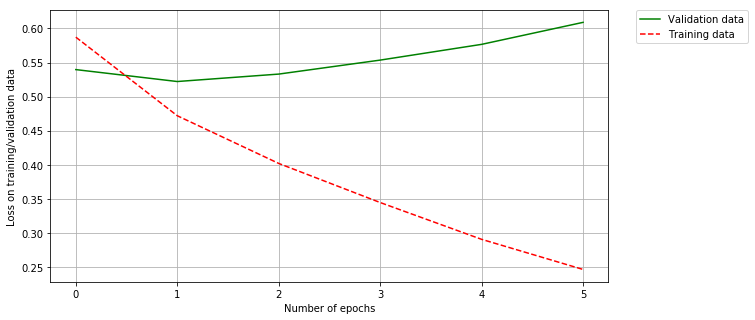

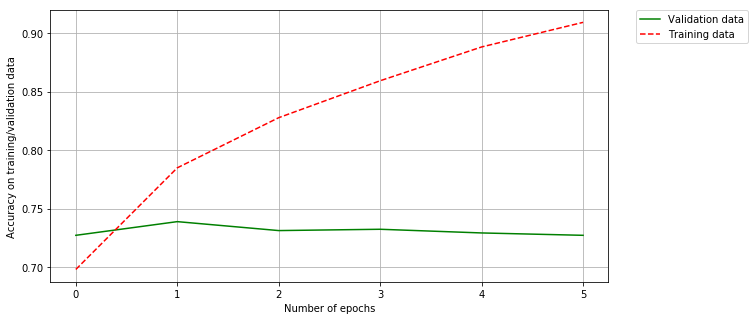

In [10]:
from numpy.random import seed
seed(1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras
from keras.layers.advanced_activations import LeakyReLU, PReLU
# define network
model = Sequential()
model.add(Dense(50, input_shape=(X_train.shape[1],), activation="linear",
                kernel_initializer=keras.initializers.he_normal(seed=1)))
model.add(Activation('relu'))

#model.add(LeakyReLU(alpha=.3))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=6, verbose=2, validation_data=(X_val, y_val), batch_size = 256)
plot_history(history)

In [11]:
print("Train")
y_pred_class = model.predict_proba(X_train)
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_train)
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))

print("Validation")
y_pred_class = model.predict(X_val)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_val)
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class))

Train
Accuracy:  0.9518299724615794
Auroc:  0.9892726160088527
Validation
Accuracy:  0.7271704903283851
Auroc:  0.7968335160176077


#### Still overfits, we decrease units to 25 and introduce regularization

# Dense Layer 25 with regularization

Train on 45028 samples, validate on 4446 samples
Epoch 1/10
 - 70s - loss: 0.7184 - accuracy: 0.6833 - val_loss: 0.7200 - val_accuracy: 0.7117
Epoch 2/10
 - 70s - loss: 0.7228 - accuracy: 0.7273 - val_loss: 0.7265 - val_accuracy: 0.7157
Epoch 3/10
 - 72s - loss: 0.7233 - accuracy: 0.7374 - val_loss: 0.7310 - val_accuracy: 0.7150
Epoch 4/10
 - 70s - loss: 0.7200 - accuracy: 0.7466 - val_loss: 0.7343 - val_accuracy: 0.7155
Epoch 5/10
 - 70s - loss: 0.7156 - accuracy: 0.7521 - val_loss: 0.7353 - val_accuracy: 0.7164
Epoch 6/10
 - 70s - loss: 0.7109 - accuracy: 0.7578 - val_loss: 0.7356 - val_accuracy: 0.7175
Epoch 7/10
 - 80s - loss: 0.7061 - accuracy: 0.7638 - val_loss: 0.7277 - val_accuracy: 0.7308
Epoch 8/10
 - 70s - loss: 0.7016 - accuracy: 0.7659 - val_loss: 0.7324 - val_accuracy: 0.7233
Epoch 9/10
 - 70s - loss: 0.6973 - accuracy: 0.7682 - val_loss: 0.7477 - val_accuracy: 0.7083
Epoch 10/10
 - 72s - loss: 0.6927 - accuracy: 0.7726 - val_loss: 0.7295 - val_accuracy: 0.7359


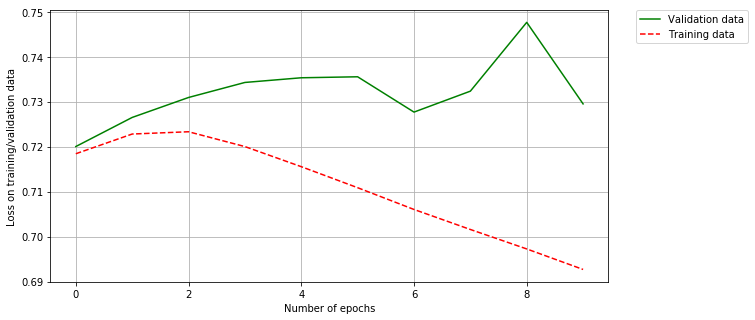

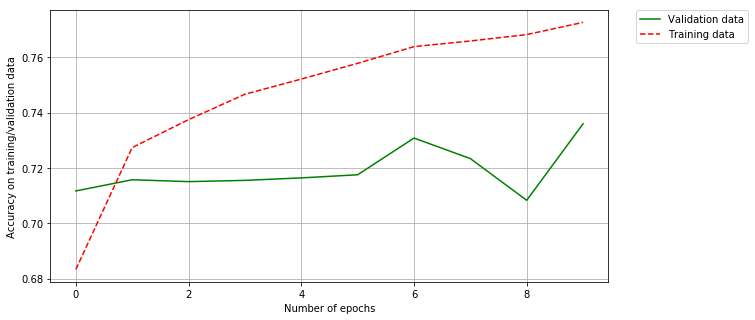

In [12]:
from numpy.random import seed
seed(1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras
from keras.layers.advanced_activations import LeakyReLU, PReLU
# define network
model = Sequential()
model.add(Dense(25, input_shape=(X_train.shape[1],), activation="linear",
                kernel_initializer=keras.initializers.he_normal(seed=1),
                kernel_regularizer=keras.regularizers.l2(0.0005),
                activity_regularizer=keras.regularizers.l1(0.0005)))
model.add(Activation('relu'))

#model.add(LeakyReLU(alpha=.3))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, verbose=2, validation_data=(X_val, y_val), batch_size = 256)
plot_history(history)

In [13]:
from sklearn import metrics

print("Train")
y_pred_class = model.predict_proba(X_train)
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_train)
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))

print("Validation")
y_pred_class = model.predict(X_val)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_val)
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class))

Train
Accuracy:  0.8257528648840722
Auroc:  0.9097051219180006
Validation
Accuracy:  0.7359424201529464
Auroc:  0.8047008055460847


#### Better, but perhaps needs less regularisation

# Dense Layer 25 with only L2 regularization

Train on 45028 samples, validate on 4446 samples
Epoch 1/20
 - 72s - loss: 0.6568 - accuracy: 0.6801 - val_loss: 0.6389 - val_accuracy: 0.7065
Epoch 2/20
 - 72s - loss: 0.6312 - accuracy: 0.7172 - val_loss: 0.6277 - val_accuracy: 0.7105
Epoch 3/20
 - 72s - loss: 0.6248 - accuracy: 0.7218 - val_loss: 0.6262 - val_accuracy: 0.7155
Epoch 4/20
 - 72s - loss: 0.6217 - accuracy: 0.7307 - val_loss: 0.6316 - val_accuracy: 0.7177
Epoch 5/20
 - 82s - loss: 0.6189 - accuracy: 0.7337 - val_loss: 0.6300 - val_accuracy: 0.7222
Epoch 6/20
 - 72s - loss: 0.6164 - accuracy: 0.7393 - val_loss: 0.6258 - val_accuracy: 0.7301
Epoch 7/20
 - 72s - loss: 0.6142 - accuracy: 0.7443 - val_loss: 0.6259 - val_accuracy: 0.7294
Epoch 8/20
 - 71s - loss: 0.6142 - accuracy: 0.7459 - val_loss: 0.6327 - val_accuracy: 0.7197
Epoch 9/20
 - 71s - loss: 0.6116 - accuracy: 0.7485 - val_loss: 0.6354 - val_accuracy: 0.7224
Epoch 10/20
 - 72s - loss: 0.6090 - accuracy: 0.7512 - val_loss: 0.6279 - val_accuracy: 0.7305
Epoch 11/2

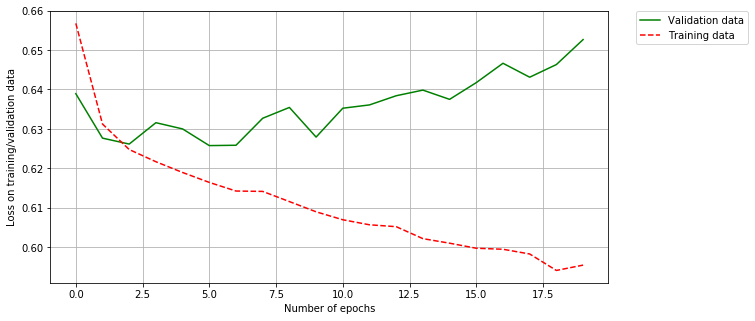

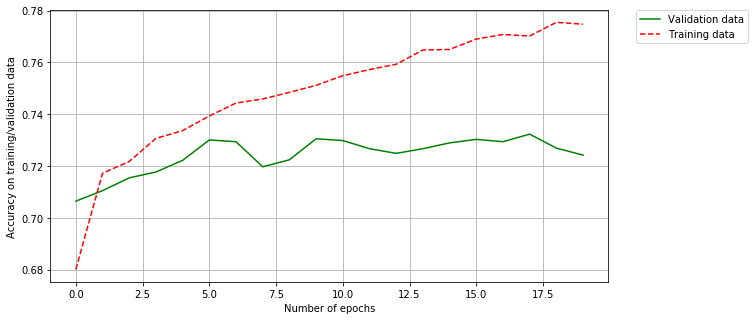

In [14]:
from numpy.random import seed
seed(1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras
from keras.layers.advanced_activations import LeakyReLU, PReLU
# define network
model = Sequential()
model.add(Dense(25, input_shape=(X_train.shape[1],), activation="linear",
                kernel_initializer=keras.initializers.he_normal(seed=1),
                kernel_regularizer=keras.regularizers.l2(0.0005)))
model.add(Activation('relu'))

#model.add(LeakyReLU(alpha=.3))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, verbose=2, validation_data=(X_val, y_val), batch_size = 256)
plot_history(history)

In [15]:
print("Train")
y_pred_class = model.predict_proba(X_train)
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_train)
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))

print("Validation")
y_pred_class = model.predict(X_val)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_val)
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class))

Train
Accuracy:  0.8302167540197211
Auroc:  0.9118182721425557
Validation
Accuracy:  0.7242465137201979
Auroc:  0.8067552577370923


# Dense Layer 25 with only L1 regularization

Train on 45028 samples, validate on 4446 samples
Epoch 1/20
 - 73s - loss: 0.7121 - accuracy: 0.6925 - val_loss: 0.7113 - val_accuracy: 0.7276
Epoch 2/20
 - 71s - loss: 0.6876 - accuracy: 0.7933 - val_loss: 0.7009 - val_accuracy: 0.7256
Epoch 3/20
 - 72s - loss: 0.6344 - accuracy: 0.8367 - val_loss: 0.6982 - val_accuracy: 0.7249
Epoch 4/20
 - 72s - loss: 0.5786 - accuracy: 0.8727 - val_loss: 0.7058 - val_accuracy: 0.7254
Epoch 5/20
 - 72s - loss: 0.5287 - accuracy: 0.8975 - val_loss: 0.7193 - val_accuracy: 0.7135
Epoch 6/20
 - 71s - loss: 0.4860 - accuracy: 0.9209 - val_loss: 0.7371 - val_accuracy: 0.7063
Epoch 7/20
 - 71s - loss: 0.4485 - accuracy: 0.9367 - val_loss: 0.7541 - val_accuracy: 0.7065
Epoch 8/20
 - 82s - loss: 0.4184 - accuracy: 0.9504 - val_loss: 0.7682 - val_accuracy: 0.7036
Epoch 9/20
 - 72s - loss: 0.3907 - accuracy: 0.9625 - val_loss: 0.7922 - val_accuracy: 0.6993
Epoch 10/20
 - 72s - loss: 0.3676 - accuracy: 0.9696 - val_loss: 0.8130 - val_accuracy: 0.6977
Epoch 11/2

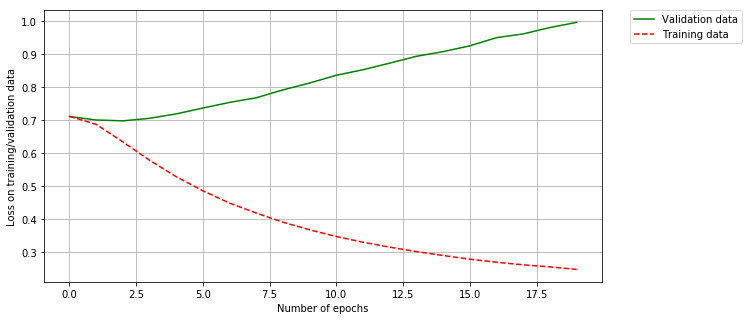

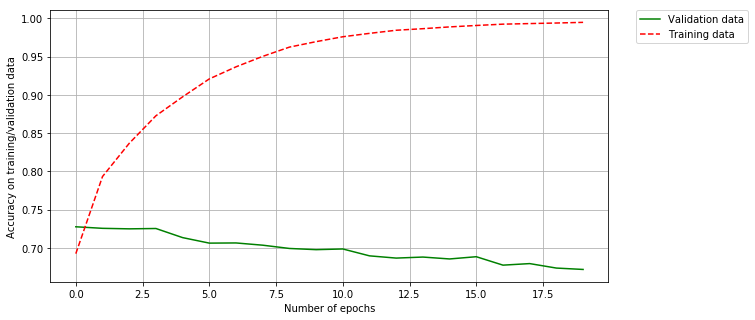

In [16]:
from numpy.random import seed
seed(1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras
from keras.layers.advanced_activations import LeakyReLU, PReLU
# define network
model = Sequential()
model.add(Dense(25, input_shape=(X_train.shape[1],), activation="linear",
                kernel_initializer=keras.initializers.he_normal(seed=1),
                activity_regularizer=keras.regularizers.l1(0.0005)))
model.add(Activation('relu'))

#model.add(LeakyReLU(alpha=.3))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, verbose=2, validation_data=(X_val, y_val), batch_size = 256)
plot_history(history)

In [17]:
print("Train")
y_pred_class = model.predict_proba(X_train)
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_train)
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))

print("Validation")
y_pred_class = model.predict(X_val)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_val)
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class))

Train
Accuracy:  0.9978902016523052
Auroc:  0.9999792288195848
Validation
Accuracy:  0.6718398560503823
Auroc:  0.7273825585661365


#### Regulatization doesn't see to be helping too much, we'll try decreasing units and increasing dropout

# Dense Layer 10, dropout 0.2

Train on 45028 samples, validate on 4446 samples
Epoch 1/6
 - 67s - loss: 0.6207 - accuracy: 0.6863 - val_loss: 0.5696 - val_accuracy: 0.7159
Epoch 2/6
 - 67s - loss: 0.5209 - accuracy: 0.7568 - val_loss: 0.5335 - val_accuracy: 0.7303
Epoch 3/6
 - 67s - loss: 0.4652 - accuracy: 0.7945 - val_loss: 0.5269 - val_accuracy: 0.7353
Epoch 4/6
 - 75s - loss: 0.4217 - accuracy: 0.8215 - val_loss: 0.5282 - val_accuracy: 0.7357
Epoch 5/6
 - 67s - loss: 0.3820 - accuracy: 0.8457 - val_loss: 0.5308 - val_accuracy: 0.7411
Epoch 6/6
 - 67s - loss: 0.3477 - accuracy: 0.8661 - val_loss: 0.5413 - val_accuracy: 0.7364


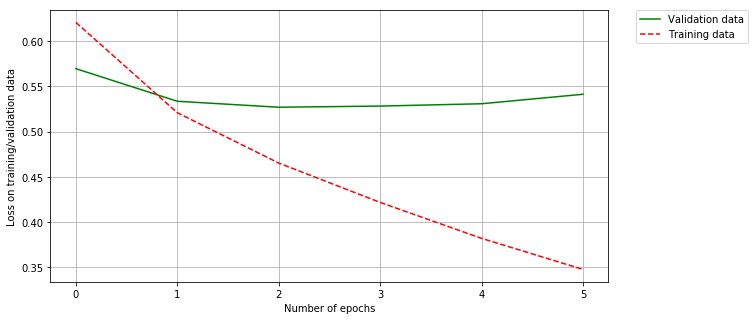

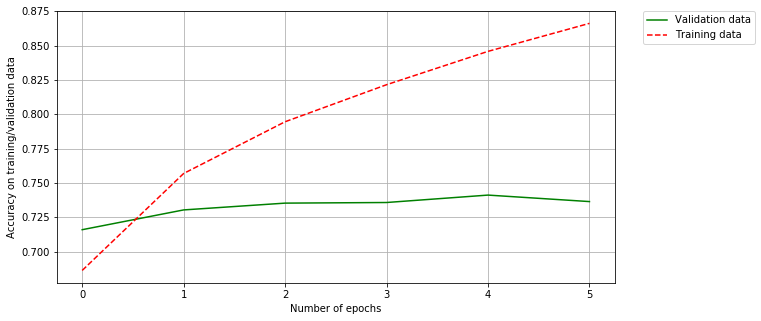

In [18]:
from numpy.random import seed
seed(1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras
from keras.layers.advanced_activations import LeakyReLU, PReLU
# define network
model = Sequential()
model.add(Dense(10, input_shape=(X_train.shape[1],), activation="linear",
                kernel_initializer=keras.initializers.he_normal(seed=1)))
model.add(Activation('relu'))

#model.add(LeakyReLU(alpha=.3))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=6, verbose=2, validation_data=(X_val, y_val), batch_size = 256)
plot_history(history)

In [19]:
print("Train")
y_pred_class = model.predict_proba(X_train)
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_train)
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))

print("Validation")
y_pred_class = model.predict(X_val)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_val)
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class))

Train
Accuracy:  0.9004397263924669
Auroc:  0.9598528761616877
Validation
Accuracy:  0.7363922627080521
Auroc:  0.8081019841220034


# Dense layer 10, dropout 0.4

Train on 45028 samples, validate on 4446 samples
Epoch 1/6
 - 67s - loss: 0.6339 - accuracy: 0.6579 - val_loss: 0.5834 - val_accuracy: 0.7245
Epoch 2/6
 - 67s - loss: 0.5539 - accuracy: 0.7459 - val_loss: 0.5470 - val_accuracy: 0.7308
Epoch 3/6
 - 67s - loss: 0.5019 - accuracy: 0.7858 - val_loss: 0.5320 - val_accuracy: 0.7357
Epoch 4/6
 - 67s - loss: 0.4609 - accuracy: 0.8139 - val_loss: 0.5279 - val_accuracy: 0.7375
Epoch 5/6
 - 76s - loss: 0.4234 - accuracy: 0.8382 - val_loss: 0.5282 - val_accuracy: 0.7337
Epoch 6/6
 - 67s - loss: 0.3903 - accuracy: 0.8561 - val_loss: 0.5347 - val_accuracy: 0.7310


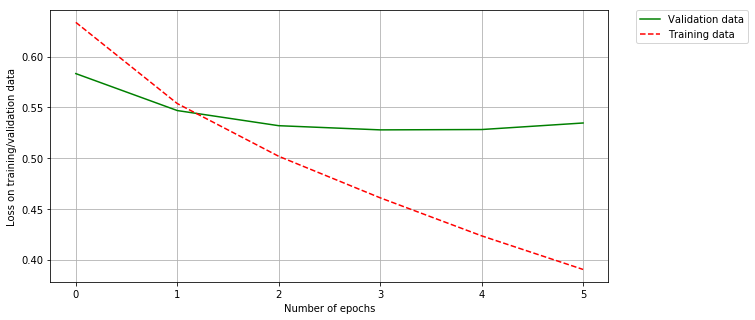

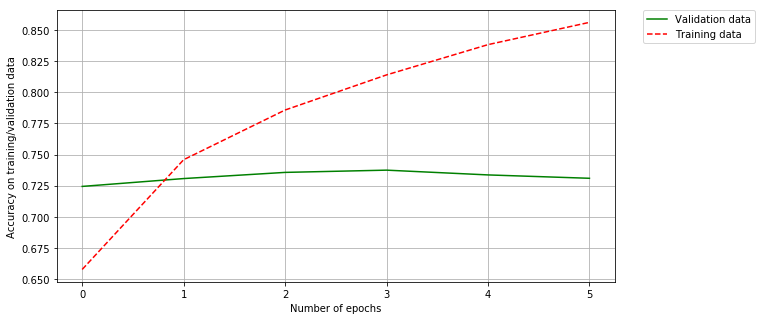

In [20]:
from numpy.random import seed
seed(1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras
from keras.layers.advanced_activations import LeakyReLU, PReLU
# define network
model = Sequential()
model.add(Dense(10, input_shape=(X_train.shape[1],), activation="linear",
                kernel_initializer=keras.initializers.he_normal(seed=1)))
model.add(Activation('relu'))

#model.add(LeakyReLU(alpha=.3))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=6, verbose=2, validation_data=(X_val, y_val), batch_size = 256)
plot_history(history)

In [21]:
print("Train")
y_pred_class = model.predict_proba(X_train)
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_train)
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))

print("Validation")
y_pred_class = model.predict(X_val)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_val)
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class))

Train
Accuracy:  0.8941991649640224
Auroc:  0.9543311936771741
Validation
Accuracy:  0.7309941520467836
Auroc:  0.8083806916679717


# Dense layer 10, dropout 0.5

Train on 45028 samples, validate on 4446 samples
Epoch 1/6
 - 67s - loss: 0.6341 - accuracy: 0.6604 - val_loss: 0.5820 - val_accuracy: 0.7164
Epoch 2/6
 - 67s - loss: 0.5515 - accuracy: 0.7330 - val_loss: 0.5457 - val_accuracy: 0.7332
Epoch 3/6
 - 67s - loss: 0.5037 - accuracy: 0.7694 - val_loss: 0.5303 - val_accuracy: 0.7346
Epoch 4/6
 - 67s - loss: 0.4673 - accuracy: 0.7905 - val_loss: 0.5248 - val_accuracy: 0.7384
Epoch 5/6
 - 67s - loss: 0.4334 - accuracy: 0.8125 - val_loss: 0.5229 - val_accuracy: 0.7425
Epoch 6/6
 - 75s - loss: 0.4040 - accuracy: 0.8315 - val_loss: 0.5275 - val_accuracy: 0.7384


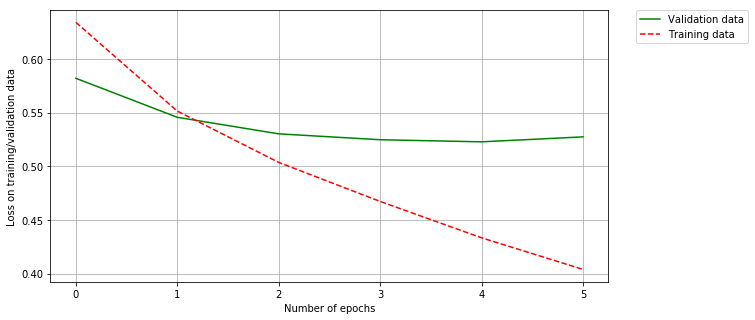

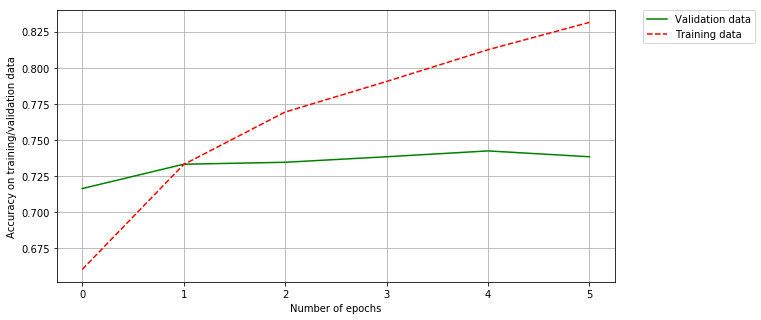

In [22]:
seed(1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras
from keras.layers.advanced_activations import LeakyReLU, PReLU
# define network
model = Sequential()
model.add(Dense(10, input_shape=(X_train.shape[1],), activation="linear",
                kernel_initializer=keras.initializers.he_normal(seed=1)))
model.add(Activation('relu'))

#model.add(LeakyReLU(alpha=.3))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=6, verbose=2, validation_data=(X_val, y_val), batch_size = 256)
plot_history(history)

In [23]:
print("Train")
y_pred_class = model.predict_proba(X_train)
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_train)
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))

print("Validation")
y_pred_class = model.predict(X_val)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_val)
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class))

Train
Accuracy:  0.8832726303633295
Auroc:  0.9491719656768756
Validation
Accuracy:  0.7384165542060279
Auroc:  0.8112091257225151


# Dense layer 10, dropout 0.6

Train on 45028 samples, validate on 4446 samples
Epoch 1/6
 - 68s - loss: 0.6359 - accuracy: 0.6468 - val_loss: 0.5876 - val_accuracy: 0.7114
Epoch 2/6
 - 68s - loss: 0.5610 - accuracy: 0.7215 - val_loss: 0.5511 - val_accuracy: 0.7326
Epoch 3/6
 - 70s - loss: 0.5186 - accuracy: 0.7591 - val_loss: 0.5361 - val_accuracy: 0.7321
Epoch 4/6
 - 68s - loss: 0.4853 - accuracy: 0.7836 - val_loss: 0.5277 - val_accuracy: 0.7398
Epoch 5/6
 - 68s - loss: 0.4583 - accuracy: 0.8027 - val_loss: 0.5233 - val_accuracy: 0.7404
Epoch 6/6
 - 69s - loss: 0.4296 - accuracy: 0.8189 - val_loss: 0.5253 - val_accuracy: 0.7386


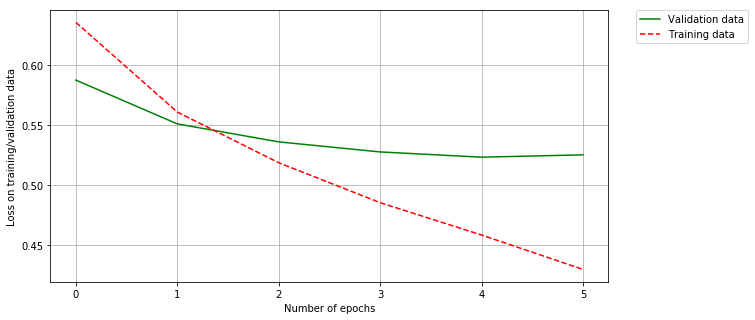

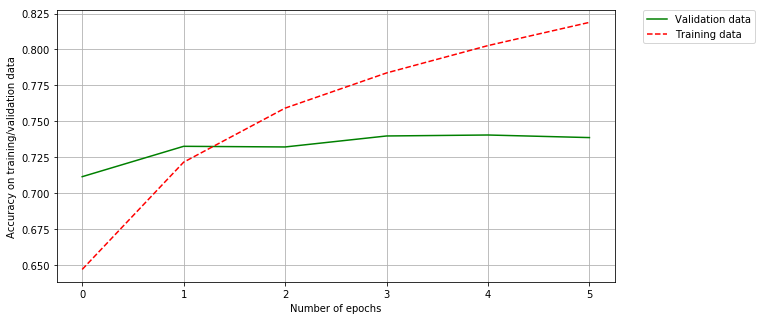

In [24]:
seed(1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras
from keras.layers.advanced_activations import LeakyReLU, PReLU
# define network
model = Sequential()
model.add(Dense(10, input_shape=(X_train.shape[1],), activation="linear",
                kernel_initializer=keras.initializers.he_normal(seed=1)))
model.add(Activation('relu'))

#model.add(LeakyReLU(alpha=.3))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=6, verbose=2, validation_data=(X_val, y_val), batch_size = 256)
plot_history(history)

In [25]:
print("Train")
y_pred_class = model.predict_proba(X_train)
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_train)
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))

print("Validation")
y_pred_class = model.predict(X_val)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_val)
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class))

Train
Accuracy:  0.8790752420715999
Auroc:  0.9464984157716038
Validation
Accuracy:  0.7386414754835807
Auroc:  0.8124188131811694


# Dense layer 10, dropout 0.6, reduce epochs to 5

Train on 45028 samples, validate on 4446 samples
Epoch 1/5
 - 73s - loss: 0.6428 - accuracy: 0.6478 - val_loss: 0.5909 - val_accuracy: 0.7179
Epoch 2/5
 - 73s - loss: 0.5704 - accuracy: 0.7291 - val_loss: 0.5524 - val_accuracy: 0.7296
Epoch 3/5
 - 68s - loss: 0.5258 - accuracy: 0.7615 - val_loss: 0.5343 - val_accuracy: 0.7314
Epoch 4/5
 - 70s - loss: 0.4923 - accuracy: 0.7848 - val_loss: 0.5265 - val_accuracy: 0.7371
Epoch 5/5
 - 68s - loss: 0.4621 - accuracy: 0.8059 - val_loss: 0.5234 - val_accuracy: 0.7373


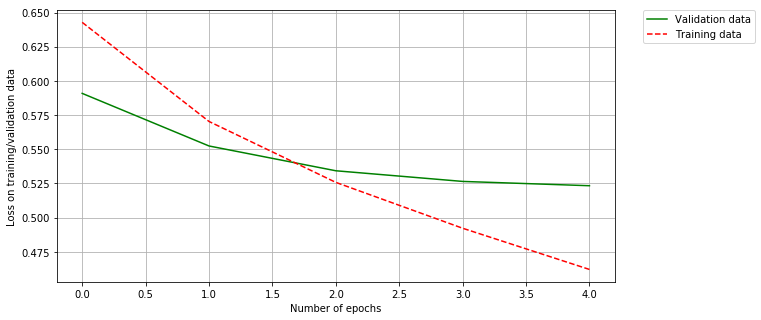

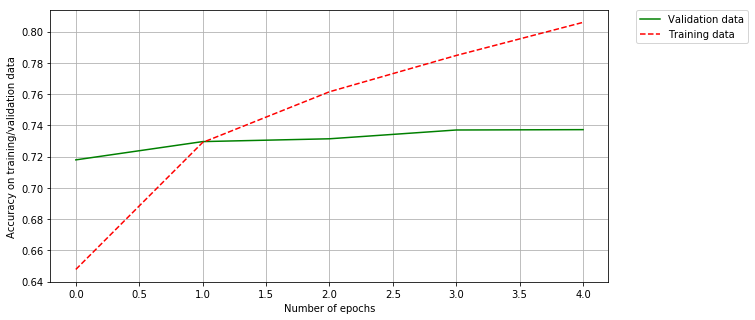

In [26]:
seed(1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras
from keras.layers.advanced_activations import LeakyReLU, PReLU
# define network
model = Sequential()
model.add(Dense(10, input_shape=(X_train.shape[1],), activation="linear",
                kernel_initializer=keras.initializers.he_normal(seed=1)))
model.add(Activation('relu'))

#model.add(LeakyReLU(alpha=.3))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, verbose=2, validation_data=(X_val, y_val), batch_size = 256)
plot_history(history)

In [27]:
print("Train")
y_pred_class = model.predict_proba(X_train)
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_train)
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))

print("Validation")
y_pred_class = model.predict(X_val)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_val)
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class))

Train
Accuracy:  0.8591098871813094
Auroc:  0.930308032788087
Validation
Accuracy:  0.7372919478182636
Auroc:  0.813391871863254


### Here we have our final model after tuning! To decrease over fit we reduced the number of units in the dense layer, increased dropout, and reduced epochs

In [28]:
start = time.time()
X_train, X_test, y_train = get_train_test(train, test = test, ngram_range = (2,5), 
                    max_features=None, random_state=1)

Fitting...
Operation Took 270.43276143074036s
(44459, 98368) (27924, 98368)
X_train:  (50046, 98368)
X_test:  (27924, 98368)


In [29]:
seed(1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras
from keras.layers.advanced_activations import LeakyReLU, PReLU
# define network
model = Sequential()
model.add(Dense(10, input_shape=(X_train.shape[1],), activation="linear",
                kernel_initializer=keras.initializers.he_normal(seed=1)))
model.add(Activation('relu'))

#model.add(LeakyReLU(alpha=.3))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, verbose=2, batch_size = 256)

Epoch 1/5
 - 73s - loss: 0.6308 - accuracy: 0.6592
Epoch 2/5
 - 73s - loss: 0.5585 - accuracy: 0.7296
Epoch 3/5
 - 73s - loss: 0.5162 - accuracy: 0.7618
Epoch 4/5
 - 73s - loss: 0.4793 - accuracy: 0.7849
Epoch 5/5
 - 81s - loss: 0.4518 - accuracy: 0.8061


In [30]:
y_pred_class = model.predict_proba(X_test)

In [31]:
test["Outcome"] = y_pred_class

In [32]:
test[["Id", "Outcome"]].to_csv("submission.csv", index=False)